## Модуль Б.  Разведочный анализ данных

#### Импортирование библиотек

In [184]:
import pandas as pd
import io
import glob
import re
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import fitz
import string
import numpy as np
import re
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns

### 1.2 Формирование структуры набора данных

### Описание структуры данных

__TitleCompany__ - Название компании

__TextPostLemat__ - обработанный, лематизированный текст 

__TextPostToken__ - обработанный, токенизированный и лематизированный текст (лематизирован другим способом нежели TextPostLemat)

__bigram__ - биграммы обработанного и лематизированного текста

__trigram__ - триграммы обработанного и лематизированного текста

__keyword__ - ключевые слова обработанного и лематизированного текста

__clustersAgglomerative__ - кластеры, образованные моделью Agglomerative

__clustersKmeans__ - кластеры, образованные моделью Kmeans

__clustersSpectral__ - кластеры, образованные моделью Spectral

#### Установка библиотек

### 2.1 Поиск ключевых слов/n-грамм. Векторизация текстов

In [78]:
dfHabr1 = pd.read_csv(r'C:\Users\МОиБД\Downloads\Report1.csv')

In [79]:
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

Из-за проблем с чтением нужно заново токенизировать текст, именно поэтому заново прописываю метод токенизации на лемматизированном тексте

In [80]:
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

In [81]:
prep_text1 = [tokenize(text.lower()) for text in tqdm(dfHabr1['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/6 [00:00<?, ?it/s]

In [82]:
dfHabr1['TextPostToken'] = prep_text1

In [83]:
dfHabr1['bigram'] = ''
dfHabr1['trigram'] = ''
dfHabr1['keyword'] = ''

#### Создание биграммы, триграммы и ключевых слов, а также добавления их в датафрейм

In [84]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfHabr1['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfHabr1['keyword'][i] = ', '.join(top_words)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [86]:
dfHabr1.head()

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword
0,Нетология,"Системы, за которые нужно отвечать, есть в го...",система нужно отвечать государственный структу...,"[система, нужно, отвечать, государственный, ст...","[(система, нужно), (нужно, отвечать), (отвечат...","[(система, нужно, отвечать), (нужно, отвечать,...","работа, инженер, системный, система, работать,..."
1,Сбер,Не все регулярные офлайн-мероприятия возвраща...,весь регулярный офлайн мероприятие возвращатьс...,"[весь, регулярный, офлайн, мероприятие, возвра...","[(весь, регулярный), (регулярный, офлайн), (оф...","[(весь, регулярный, офлайн), (регулярный, офла...","робот, дисциплина, соревнование, robogames, го..."
2,Skillbox,Уходящий 2022 год был богат на новинки и событ...,уходить год богатый новинка событие запускать ...,"[уходить, год, богатый, новинка, событие, запу...","[(уходить, год), (год, богатый), (богатый, нов...","[(уходить, год, богатый), (год, богатый, новин...","год, направление, программа, курс, рынок, разр..."
3,Иннотех,Начну с небольшой предыстории и представлюсь. ...,начинать небольшой предыстория представляться ...,"[начинать, небольшой, предыстория, представлят...","[(начинать, небольшой), (небольшой, предыстори...","[(начинать, небольшой, предыстория), (небольшо...","дизайнер, весь, дизайн, решение, находить, сов..."
4,СберМаркет,"Привет! Меня зовут Анна Большешапова, я продук...",привет звать анна большешаповый продуктовый ди...,"[привет, звать, анна, большешаповый, продуктов...","[(привет, звать), (звать, анна), (анна, больше...","[(привет, звать, анна), (звать, анна, большеша...","text, задача, время, делать, день, проблема, н..."


In [87]:
# метод препроцессинга, необходимый для полной очистки всего ненужного
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [88]:
# вызов препроцессинга и трансформация
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [89]:
text = dfHabr1['TextPostLemat']

In [90]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 15.6 ms
Wall time: 17.9 ms


In [91]:
len(dfHabr2)

6

#### Векторизация текста, для дальнейшей обработки

In [92]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [93]:
count_matrix.toarray()[:2,:200]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0, 10,  2,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  3,
         3,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,
         0,  0,  0,  0,

In [94]:
count_matrix.shape

(6, 11064)

In [95]:
vectorizer.get_feature_names_out()[:50]

array(['academy', 'academy проводить', 'academy проводить выступление',
       'adobe', 'adobe illustrator', 'adobe illustrator почему',
       'adobe illustrator рисование', 'adobe photoshop',
       'adobe photoshop часто', 'alameda', 'alameda county',
       'alameda county fairgrounds', 'and', 'and carry',
       'and carry соревнование', 'animated', 'animated apitext',
       'animated apitext библиотека', 'animated apitext изначальный',
       'animated apitext новый', 'animated apitext ребята',
       'animated nativeanimatedhelper',
       'animated nativeanimatedhelper указывать', 'animated reanimated',
       'animated reanimated посмотреть', 'animated timing',
       'animated timing animationvalue', 'animated value',
       'animated value currenttext', 'animated показывать',
       'animated показывать хороший', 'animated представлять',
       'animated представлять набор', 'animatedtext',
       'animatedtext начинать', 'animatedtext начинать встраивать',
       'animatio

In [96]:
len(vectorizer.get_feature_names_out())

11064

### 2.3 Кластеризация

Agglomerative - это метод кластеризации, который относится к иерархической кластеризации. Он работает путем объединения каждого отдельного кластера с процессом, который повторяется до тех пор, пока все кластеры не будут объединены в один кластер. Также полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

In [115]:
# Выбор и применение алгоритма кластеризации
agg = AgglomerativeClustering(n_clusters=6).fit(count_matrix.toarray())

In [116]:
# Получение меток кластеров
labelsAgglomerative = agg.labels_
clusters1 = agg.labels_.tolist()

In [117]:
agg.labels_

array([3, 5, 4, 1, 2, 0], dtype=int64)

In [118]:
dfHabr1['clustersAgglomerative'] = clusters1

Kmeans - это метод кластеризации, который относится к семейству неконтролируемого обучения. Он используется для разбиения данных на группы на основе их сходства. Алгоритм начинается с выбора случайных центров кластеров, затем каждая точка данных присваивается к ближайшему центру кластера. Затем центры кластеров пересчитываются на основе точек данных, которые были присвоены кластеру, и процесс повторяется до тех пор, пока центры кластеров не стабилизируются. Также полезен в случаях, когда нужно разбить данные на группы на основе их сходства. 

In [121]:
# Метод к-средних - KMeans
km = KMeans(n_clusters=6).fit(count_matrix.toarray())

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [122]:
labelsKmeans = km.labels_
clusters2 = km.labels_.tolist()

In [123]:
dfHabr1['clustersKmeans'] = clusters2

Spectral - это метод кластеризации, который использует линейную алгебру для разбиения данных на группы на основе их сходства. Он преобразует данные в новое пространство признаков, где они могут быть более легко разделены на группы. Затем он использует методы кластеризации, такие как K-means, для разбиения данных на группы. Spectral может быть полезен в случаях, когда нужно разбить данные на группы на основе их сходства, но данные не могут быть разделены на группы в исходном пространстве признаков. 

In [125]:
# Создание модели DBSCAN
spectral = SpectralClustering(n_clusters=6).fit(count_matrix.toarray())

C:\ProgramData\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [126]:
labelsSpectral = spectral.labels_
clusters3 = spectral.labels_.tolist()

In [127]:
dfHabr1['clustersSpectral'] = clusters3

In [128]:
print(labelsSpectral)

[0 1 3 5 2 4]


In [129]:
print(labelsKmeans)

[1 2 5 0 3 4]


In [130]:
print(labelsAgglomerative)

[3 5 4 1 2 0]


In [131]:
dfHabr1.head()

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,Нетология,"Системы, за которые нужно отвечать, есть в го...",система нужно отвечать государственный структу...,"[система, нужно, отвечать, государственный, ст...","[(система, нужно), (нужно, отвечать), (отвечат...","[(система, нужно, отвечать), (нужно, отвечать,...","работа, инженер, системный, система, работать,...",3,1,0
1,Сбер,Не все регулярные офлайн-мероприятия возвраща...,весь регулярный офлайн мероприятие возвращатьс...,"[весь, регулярный, офлайн, мероприятие, возвра...","[(весь, регулярный), (регулярный, офлайн), (оф...","[(весь, регулярный, офлайн), (регулярный, офла...","робот, дисциплина, соревнование, robogames, го...",5,2,1
2,Skillbox,Уходящий 2022 год был богат на новинки и событ...,уходить год богатый новинка событие запускать ...,"[уходить, год, богатый, новинка, событие, запу...","[(уходить, год), (год, богатый), (богатый, нов...","[(уходить, год, богатый), (год, богатый, новин...","год, направление, программа, курс, рынок, разр...",4,5,3
3,Иннотех,Начну с небольшой предыстории и представлюсь. ...,начинать небольшой предыстория представляться ...,"[начинать, небольшой, предыстория, представлят...","[(начинать, небольшой), (небольшой, предыстори...","[(начинать, небольшой, предыстория), (небольшо...","дизайнер, весь, дизайн, решение, находить, сов...",1,0,5
4,СберМаркет,"Привет! Меня зовут Анна Большешапова, я продук...",привет звать анна большешаповый продуктовый ди...,"[привет, звать, анна, большешаповый, продуктов...","[(привет, звать), (звать, анна), (анна, больше...","[(привет, звать, анна), (звать, анна, большеша...","text, задача, время, делать, день, проблема, н...",2,3,2


#### Визуализация распределения кластеров

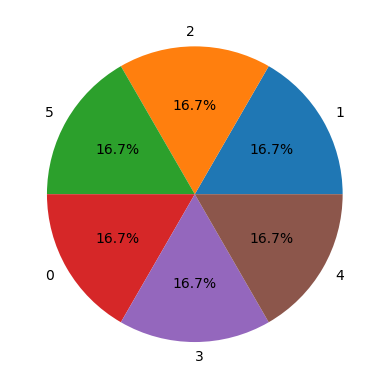

In [133]:
# визуализация распределения кластеров Kmeans
cluster_counts = dfHabr1['clustersKmeans'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

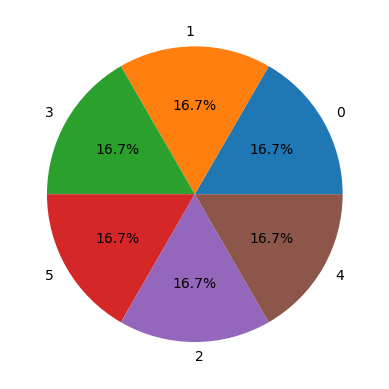

In [134]:
# визуализация распределения кластеров Spectral
cluster_counts = dfHabr1['clustersSpectral'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

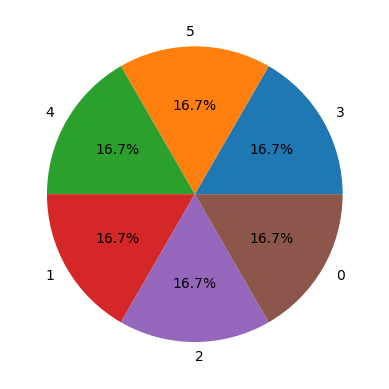

In [186]:
# визуализация распределения кластеров Agglomerative
cluster_counts = dfHabr1['clustersAgglomerative'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

#### Оценка качества кластеризации

In [137]:
a = (dfHabr1['clustersKmeans'] - dfHabr1['clustersKmeans'].mean()) / dfHabr1['clustersKmeans'].std()
a1 = (dfHabr1['clustersAgglomerative'] - dfHabr1['clustersAgglomerative'].mean()) / dfHabr1['clustersAgglomerative'].std()
a2 = (dfHabr1['clustersSpectral'] - dfHabr1['clustersSpectral'].mean()) / dfHabr1['clustersSpectral'].std()

In [138]:
data_norm_kmeans = a.values.reshape(-1, 1)
data_norm_agg = a1.values.reshape(-1, 1)
data_norm_spec = a2.values.reshape(-1, 1)

In [142]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_kmeans, km.labels_)
print("Silhouette  score:", silhouette_avg)

ValueError: Number of labels is 6. Valid values are 2 to n_samples - 1 (inclusive)

In [140]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_agg, agg.labels_)
print("Silhouette  score:", silhouette_avg)

ValueError: Number of labels is 6. Valid values are 2 to n_samples - 1 (inclusive)

In [141]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_spec, spectral.labels_)
print("Silhouette  score:", silhouette_avg)

ValueError: Number of labels is 6. Valid values are 2 to n_samples - 1 (inclusive)

Оценку качества кластеризации модели не прошли, так как у них проблема из-за количества кластеров

### 2.2 Тематическое моделирование

LDA - это метод машинного обучения, который используется для анализа тематической структуры в больших наборах документов. Который использует модель вероятности, чтобы определить, какие темы присутствуют в каждом документе, и какие слова связаны с каждой темой. LDA может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

In [144]:
# создание модели LDA
lda_model = LatentDirichletAllocation(n_components=6, random_state=0)
lda_model.fit(count_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: показывать, сделать, новый, помимо, понимать, сразу, начинать, поделиться, определять, важный
Topic 1: text, задача, время, делать, день, нужно, успевать, проблема, мочь, тип
Topic 2: показывать, сделать, новый, помимо, понимать, сразу, начинать, поделиться, определять, важный
Topic 3: робот, дизайнер, дисциплина, весь, соревнование, год, команда, robogames, находить, мочь
Topic 4: text, анимация, animated, text text, работа, тред, весь, react, react native, const
Topic 5: работа, инженер, системный, системный инженер, год, работать, система, направление, знание, программа


In [145]:
print(str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword']))

5    text, анимация, animated, работа, тред, react,...
Name: keyword, dtype: object


In [146]:
len(lda_model.components_)

6

In [147]:
lda_model.components_

array([[0.16666667, 0.16666667, 0.16666667, ..., 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, ..., 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, ..., 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, ..., 2.16666665, 1.16666665,
        1.16666665],
       [0.16666667, 0.16666667, 0.16666667, ..., 0.16666667, 0.16666667,
        0.16666667],
       [1.16666664, 1.16666664, 1.16666664, ..., 0.16666667, 0.16666667,
        0.16666667]])

In [148]:
# создание матрицы документ-термин
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfHabr2)

In [149]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [150]:
tfidf_matrix.shape

(6, 1948)

NMF - это метод машинного обучения, который используется для разложения матрицы на две с неотрицательными элементами. Он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д. NMF может использоваться в различных областях, таких как обработка изображений, текстовый анализ и т.д

In [151]:
# создание модели NMF
nmf_model = NMF(n_components=6, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: text, задача, время, календарь, проблема, день, график, сколько, час, успевать
Topic 1: направление, год, курс, образовательный, директор, рынок, программный, разработчик, программа, планировать
Topic 2: робот, дисциплина, соревнование, robogames, автономный, запрещать, участник, соперник, фунт, битва
Topic 3: дизайнер, дизайн, иконка, иллюстрация, совет, решение, сайт, интерфейс, количество, находить
Topic 4: системный, инженер, работа, система, devops, компания, специалист, знание, приходиться, работать
Topic 5: text, animated, анимация, тред, const, react, native, javascript, свойство, библиотека


In [152]:
len(nmf_model.components_)

6

In [153]:
nmf_model.components_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02721577, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01467328, ..., 0.01467328, 0.01467328,
        0.02934656],
       [0.        , 0.09512567, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

LSA - это метод машинного обучения, который используется для анализа структуры в больших наборах текстовых данных. Он использует матричные вычисления для определения близости между словами и документами. LSA может быть полезен в случаях, когда вы хотите определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.

In [155]:
# создание модели LSA
lsa_model = TruncatedSVD(n_components=6, random_state=0)
lsa_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: text, задача, animated, анимация, работа, время, системный, дизайнер, инженер, весь
Topic 1: системный, инженер, робот, работа, год, направление, курс, рынок, дизайнер, знание
Topic 2: робот, дисциплина, соревнование, robogames, автономный, запрещать, участник, фунт, соперник, битва
Topic 3: дизайнер, дизайн, иллюстрация, иконка, совет, решение, количество, сайт, интерфейс, comhttps
Topic 4: системный, инженер, devops, система, работа, приходиться, центр, дата, linux, компания
Topic 5: задача, время, календарь, день, проблема, график, сколько, час, успевать, тип


In [156]:
len(lsa_model.components_)

6

In [157]:
lsa_model.components_

array([[ 0.00483911,  0.02149944,  0.00123066, ...,  0.00123066,
         0.00123066,  0.00246132],
       [ 0.01202264,  0.02816299,  0.00310654, ...,  0.00310654,
         0.00310654,  0.00621307],
       [-0.00338288, -0.0068577 ,  0.01401697, ...,  0.01401697,
         0.01401697,  0.02803395],
       [-0.00838981,  0.0918283 , -0.00064581, ..., -0.00064581,
        -0.00064581, -0.00129161],
       [-0.01875566, -0.00601476,  0.00097998, ...,  0.00097998,
         0.00097998,  0.00195995],
       [ 0.00018278, -0.01103478, -0.00016741, ..., -0.00016741,
        -0.00016741, -0.00033482]])

В итоге лучшей моделью является LDA, т.к. она в данном случае самая нужная, и работает лучше всего (определяет тематическую структуру в большом наборе документов, таких как статьи и т.д.)

#### Визуализация тематического моделирования

In [158]:
pyLDAvis.enable_notebook()

In [159]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

5    text, анимация, animated, работа, тред, react,...
Name: keyword, dtype: object


In [160]:
# визуализация модели LDA
panel = pyLDAvis.sklearn.prepare(lda_model, count_matrix, vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\МОиБД\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -56.468956   3.580004       1        1   0.006963
1      89.655159  61.163101       2        1  14.503661
2      -4.429116  85.266380       3        1   0.006963
3      95.671249 -35.977127       4        1  32.239637
4       5.099026 -71.430779       5        1   8.923722
5      25.975035   8.499473       6        1  44.319053, topic_info=              Term       Freq      Total Category  logprob  loglift
516           text  39.000000  39.000000  Default  30.0000  30.0000
8542         робот  37.000000  37.000000  Default  29.0000  29.0000
2754        задача  27.000000  27.000000  Default  28.0000  28.0000
3267       инженер  29.000000  29.000000  Default  27.0000  27.0000
9065     системный  26.000000  26.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
3860       команда   8.656310  17.672990   Topic6  -6.5998   0.1000
10821      человек   7.881118  13.161955   Topic6  -6.6936   0.3009
2754        задача   9.431495  27.480394   Topic6  -6.5140  -0.2557
1652         время   7.881110  23.463118   Topic6  -6.6936  -0.2772
9653   становиться   7.105932  10.748496   Topic6  -6.7972   0.3999

[348 rows x 6 columns], token_table=       Topic      Freq                            Term
term                                                  
15         5  0.871960                        animated
16         5  0.978030                animated apitext
25         5  0.816269                 animated timing
26         5  0.816269  animated timing animationvalue
27         5  0.816269                  animated value
...      ...       ...                             ...
10821      4  0.379883                         человек
10821      6  0.607812                         человек
10828      4  0.841169                 человек команда
10828      6  0.210292                 человек команда
10830      4  1.005001            человек команда фунт

[339 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [161]:
# визуализация модели NMF
panel = pyLDAvis.sklearn.prepare(nmf_model, tfidf_matrix, tfidf_vectorizer, mds='tsne', sort_topics=False)
panel

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\МОиБД\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       1.428067  -6.784307       1        1  13.696368
1       3.406663 -26.938353       2        1  21.354097
2      16.828020 -42.112282       3        1  16.602912
3     -16.339664 -22.473017       4        1  17.761602
4      21.908350 -18.904760       5        1  19.829992
5      -6.853294 -44.324532       6        1  10.755029, topic_info=            Term      Freq     Total Category  logprob  loglift
120         text  1.000000  1.000000  Default  30.0000  30.0000
1494       робот  0.000000  0.000000  Default  29.0000  29.0000
1566   системный  0.000000  0.000000  Default  28.0000  28.0000
4       animated  0.000000  0.000000  Default  27.0000  27.0000
433     дизайнер  0.000000  0.000000  Default  26.0000  26.0000
...          ...       ...       ...      ...      ...      ...
1307  приложение  0.064602  0.190771   Topic6  -4.8615   1.1470
1406      работа  0.072484  0.495730   Topic6  -4.7464   0.3071
266         весь  0.062074  0.352445   Topic6  -4.9014   0.4932
1407    работать  0.059705  0.302789   Topic6  -4.9403   0.6062
1581   следующий  0.048445  0.078446   Topic6  -5.1493   1.7478

[443 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
120       1  0.692483   text
120       6  0.692483   text
1494      3  1.334355  робот, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

К сожалению, модель LSA через pyLDAvis невозможно вывести

In [163]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

5    text, анимация, animated, работа, тред, react,...
Name: keyword, dtype: object


#### Распределение кластеров по тематическому моделированию

In [177]:
# Массив, в котором будут сохраняться перебранные lda компоненты
topics = []

for i, topic in enumerate(lda_model.components_):
    # топ векторизованных слов
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    topic_string = f"Topic {i}: {', '.join(top_words)}"
    # добавление
    topics.append(topic_string)

In [178]:
dfCosinTest = pd.DataFrame({'texts': topics})

In [179]:
dfj = {'texts': [], 'cos_similarities' : [], 'cluster': []}

In [180]:
# цикл, который реализует сравнение топ слов lda модели и кластеров, для правильного подбора кластера к lda модели
for i in range(0, 6):
    # выбор текста - цели
    find_nearest_to = str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == i, 'keyword'])
    # формирование весов tf-idf
    tfidf = TfidfVectorizer()
    mx_tf = tfidf.fit_transform(topics)
    new_entry = tfidf.transform([find_nearest_to])
    sdf = pd.DataFrame.sparse.from_spmatrix(mx_tf)
    new_entry = tfidf.transform([find_nearest_to])
    pd.DataFrame.sparse.from_spmatrix(new_entry)
    # создание косинуснового сходства
    cosine_similarities = cosine_similarity(new_entry, mx_tf).flatten()
    dfCosinTest['cos_similarities'] = cosine_similarities
    # сортировка, для выбора наибольшего сходства
    dfCosinTest = dfCosinTest.sort_values(by=['cos_similarities'], ascending=[0])
    dfCosinTest = dfCosinTest.reset_index(drop=True)
    dfj['texts'].append(dfCosinTest['texts'][0])
    dfj['cos_similarities'].append(dfCosinTest['cos_similarities'][0])
    dfj['cluster'].append(i)

In [181]:
dfClusters = pd.DataFrame(data = dfj)

In [182]:
dfClusters.head(15)

,texts,cos_similarities,cluster
0,"Topic 4: text, анимация, animated, text text, ...",0.816525,0
1,"Topic 0: показывать, сделать, новый, помимо, п...",0.538544,1
2,"Topic 2: показывать, сделать, новый, помимо, п...",0.771022,2
3,"Topic 3: робот, дизайнер, дисциплина, весь, со...",0.809472,3
4,"Topic 4: text, анимация, animated, text text, ...",0.428689,4
5,"Topic 1: text, задача, время, делать, день, ну...",0.658868,5


### 2.4 Разведочный анализ

C:\Users\МОиБД\AppData\Local\Temp\ipykernel_10036\785557542.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dfHabr1['clustersAgglomerative'], shade=True)


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

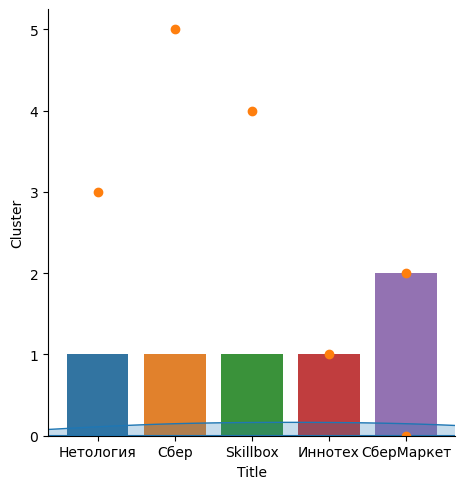

In [185]:
sns.catplot(x='TitleCompany', kind='count', data=dfHabr1)
# анализ плотности распределения целевой переменной
sns.kdeplot(dfHabr1['clustersAgglomerative'], shade=True)
# визуализация зависимости кластеров от временных признаков
plt.scatter(dfHabr1['TitleCompany'], dfHabr1['clustersAgglomerative'])
plt.xlabel('Title')
plt.ylabel('Cluster')
plt 

In [193]:
# сохраняем DataFrame в файл
dfHabr1.to_csv(r'C:\Users\МОиБД\Downloads\Report2.csv', index=False, encoding='utf-8')

### 2.5 Подготовка отчета




__2.1 Поиск ключевых слов/n-грамм. Векторизация текста__ Пункт был выполнен без нареканий. Биграммы, триграммы и векторизация выполнены успешно.

__2.2 Тематическое моделирование__ Сначала была выполнена кластеризация, потом тематическое моделирование. Само тематическое моделирование было выполнено тремя способами LDA, NMF и LSA, оно прошло успешно и была выбрана LDA.

    __2.2.1 LDA__ (лучшая модель) выбрал потому, что он может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

    __2.2.2 NMF__ выбрал потому, что он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д.

    __2.2.3 LSA__ выбрал потому, что он может быть полезен в случаях, когда нужно определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.


__2.3 Кластеризация__ Предварительная обработка данных выполнена без проблем. Кластеры показали себя одинакого, по сравнению друг с другом из-за того, что текста довольно разные и их мало, оценка кластеризации не сработало из-за маленького количества строк, в соответствии кластеров.

    __2.3.1 Agglomerative__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

    __2.3.2 Kmeans__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

    __2.3.3 Spectral__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства, но данные не могут быть разделены на группы в исходном пространстве признаков.

__2.4 Разведочный анализ__ Предварительная обработка данных выполнена полностью, без проблем.

### Вывод

В итоге датафрейм почти полностью готов к 3-ей Сессии. Но есть небольшие недочеты, по типу того, что датасет очень маленький. И проблемы связанные с этим. Такие как проблема с кластеризацией.

